<a href="https://colab.research.google.com/github/baeksumin/k-project/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 전처리

In [28]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
from google.colab import drive
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [29]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
data = pd.read_csv('/content/drive/MyDrive/[Shared]K-Project/data/mktcap_top10/KR7006840003.csv')

In [31]:
data

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,2021/12/24,0,0,0,0,0,NaN
1,2021/12/23,0,0,0,0,0,NaN
2,2021/12/22,0,0,0,0,0,NaN
3,2021/12/21,0,0,0,0,0,NaN
4,2021/12/20,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...
5521,1999/08/17,0,0,-1,0,0,NaN
5522,1999/08/16,0,0,-1,0,0,NaN
5523,1999/08/13,0,0,-1,0,0,NaN
5524,1999/08/12,0,0,-1,0,0,NaN


In [32]:
data[data['MAP_sig'] == -1]

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND


In [33]:
data['TREND'].isnull().sum()

20

In [34]:
data['TREND'] = data['TREND'].fillna(0)

In [35]:
data.isnull().sum()

TRD_DD     0
GDC_sig    0
RSI_sig    0
ROC_sig    0
MAP_sig    0
STC_sig    0
TREND      0
dtype: int64

In [36]:
data[0.1 < data['TREND']]

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
13,2021/12/07,0,0,0,0,0,1.000000
14,2021/12/06,0,0,0,0,0,0.714286
54,2021/10/08,0,0,0,0,0,0.164835
55,2021/10/07,0,0,0,0,0,0.186813
56,2021/10/06,0,0,0,0,0,0.208791
...,...,...,...,...,...,...,...
5504,1999/09/09,0,0,1,0,0,0.555556
5505,1999/09/08,0,0,1,0,0,0.444444
5506,1999/09/07,0,0,1,0,0,0.333333
5507,1999/09/06,0,0,1,0,0,0.222222


In [37]:
#최신 데이터가 뒤로 오도록 정렬
data = data.sort_values(by=['TRD_DD'])
data.set_index('TRD_DD',drop=True,inplace=True)
data.reset_index('TRD_DD',drop=False,inplace=True)
data

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,1999/08/11,0,0,1,0,0,0.0
1,1999/08/12,0,0,-1,0,0,0.0
2,1999/08/13,0,0,-1,0,0,0.0
3,1999/08/16,0,0,-1,0,0,0.0
4,1999/08/17,0,0,-1,0,0,0.0
...,...,...,...,...,...,...,...
5521,2021/12/20,0,0,0,0,0,0.0
5522,2021/12/21,0,0,0,0,0,0.0
5523,2021/12/22,0,0,0,0,0,0.0
5524,2021/12/23,0,0,0,0,0,0.0


In [38]:
# data.set_index('TRD_DD', drop=True, inplace=True)
# data

In [39]:
Y_colname = ['TREND'] #종속변수
X_remove = ['TRD_DD']
X_colname = [x for x in data.columns if x not in Y_colname + X_remove] #입력변수들
X_colname

['GDC_sig', 'RSI_sig', 'ROC_sig', 'MAP_sig', 'STC_sig']

In [40]:
def datasplit(df, Y_colname, X_colname): #데이터 분리 함수
  df_train = df.loc[0 : round(len(df) * 0.75)] 
  df_test = df.loc[round(len(df) * 0.75) + 1 : ]
  Y_train = df_train[Y_colname]
  X_train = df_train[X_colname]
  Y_test = df_test[Y_colname]
  X_test = df_test[X_colname]
  return X_train, X_test, Y_train, Y_test

In [41]:
X_train, X_test, Y_train, Y_test = datasplit(data, Y_colname, X_colname)

In [42]:
print('X_train :', X_train.shape, 'Y_train :', Y_train.shape) 
print('X_test :', X_test.shape, 'Y_test :', Y_test.shape)

X_train : (4145, 5) Y_train : (4145, 1)
X_test : (1381, 5) Y_test : (1381, 1)


In [43]:
Y_train

,TREND
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
4140,-0.833333
4141,-0.750000
4142,-0.666667
4143,-0.416667


In [44]:
#array로 변환
X_train_arr = X_train.values
Y_train_arr = Y_train.values
X_test_arr = X_test.values
Y_test_arr = Y_test.values

In [45]:
seq_length = 12 #몇개의 입력데이터로 차분 데이터 생성할지에 대한 파라미터. 지금은 12라고 가정. 나중에 반복문을 통해 sequence 최적화가 필요할듯.
X_train, Y_train = [], []
for index in range(len(X_train_arr) - seq_length): #sequence개의 데이터만큼 차분데이터 분석에 사용하므로, 총 데이터 개수 - sequence개수가 전체 데이터의 길이 --> 총길이만큼 돌리는 것이므로, 기존 차원을 뜻하는 (row, column) 꼴에는 변함 없음 --> 2차원 데이터
  X_train.append(np.array(X_train_arr[index:index + seq_length])) #X_train 데이터 --> index가 sequence인 1차원 데이터 생성 --> sequence를 뜻하는 차원 생성
  Y_train.append(np.ravel(Y_train_arr[index + seq_length:index + seq_length + 1])) #Y_train 데이터 --> index가 sequence인 1차원 데이터 생성 --> 그러나 ravel() 로 차원축소 --> sequence차원 생성되지 않음.
X_train, Y_train = np.array(X_train), np.array(Y_train) #array로 저장되어있는 리스트를 array로 변환해서 저장

In [46]:
X_test, Y_test = [], [] #동일한 과정 test데이터셋에도 적용
for index in range(len(X_test_arr) - seq_length):
  X_test.append(np.array(X_test_arr[index:index + seq_length])) 
  Y_test.append(np.ravel(Y_test_arr[index + seq_length:index + seq_length + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [47]:
print('X_train :', X_train.shape, 'Y_train :', Y_train.shape) #X/Y 분리가 잘 됨. 데이터 전처리 과정 완료
print('X_test :', X_test.shape, 'Y_test :', Y_test.shape)

X_train : (4133, 12, 5) Y_train : (4133, 1)
X_test : (1369, 12, 5) Y_test : (1369, 1)


In [48]:
#텐서로 변환 : 파이토치 모델은 float32타입으로만 돌아감.
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

In [49]:
X_train.shape

torch.Size([4133, 12, 5])

In [50]:
X_train.dtype

torch.float32

# 모델링

In [51]:
# Model Class 생성

class SignalPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(SignalPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

In [52]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), Y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), Y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [53]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=100

In [54]:
# Training Model
model = SignalPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, Y_train, X_test, Y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.3557 test loss: 0.3475
Epoch 10 train loss: 0.3525 test loss: 0.3443
Epoch 20 train loss: 0.3505 test loss: 0.3423
Epoch 30 train loss: 0.3495 test loss: 0.3414
Epoch 40 train loss: 0.3492 test loss: 0.3411
Epoch 50 train loss: 0.3491 test loss: 0.3411
Epoch 60 train loss: 0.3491 test loss: 0.3411
Epoch 70 train loss: 0.3491 test loss: 0.3411
Epoch 80 train loss: 0.3491 test loss: 0.3411
Epoch 90 train loss: 0.3491 test loss: 0.3411


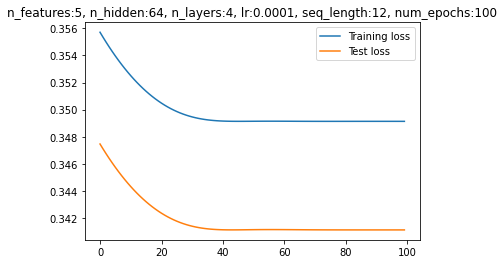

In [55]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# 예측

In [56]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [57]:
preds

[-0.00027396902441978455,
 -0.0002490207552909851,
 -0.00019644573330879211,
 -0.0001297350972890854,
 -6.148964166641235e-05,
 -1.5087425708770752e-07,
 5.022995173931122e-05,
 8.884631097316742e-05,
 0.00011679716408252716,
 0.00013604946434497833,
 0.00014870241284370422,
 0.0001566372811794281,
 0.0001613665372133255,
 0.00016400963068008423,
 0.00016537867486476898,
 0.00016597844660282135,
 0.00016617588698863983,
 0.00016614794731140137,
 0.00016602873802185059,
 0.00016588903963565826,
 0.0001657474786043167,
 0.00016562826931476593,
 0.00016553327441215515,
 0.00016545318067073822,
 0.00016539357602596283,
 0.0001653488725423813,
 0.0001653190702199936,
 0.00016530044376850128,
 0.0001652836799621582,
 0.0001652650535106659,
 0.00016526319086551666,
 0.00016525574028491974,
 0.0001652538776397705,
 0.00016525015234947205,
 0.00016524642705917358,
 0.00016524642705917358,
 0.00016524828970432281,
 0.00019344687461853027,
 0.0002302359789609909,
 0.00025845877826213837,
 0.00027

In [62]:
Y_test_array = np.array(Y_test).reshape(-1,1)
real = list(Y_test_array.flatten())
real

[0.85714287,
 0.2857143,
 0.14285715,
 0.0,
 -0.14285715,
 -0.5714286,
 -0.71428573,
 -0.85714287,
 -1.0,
 -0.9259259,
 -0.7037037,
 -0.6296296,
 -0.5555556,
 -0.4814815,
 -0.4074074,
 -0.18518518,
 -0.11111111,
 -0.037037037,
 0.037037037,
 0.11111111,
 0.33333334,
 0.4074074,
 0.4814815,
 0.5555556,
 0.6296296,
 0.8518519,
 0.9259259,
 1.0,
 0.875,
 0.75,
 0.375,
 0.25,
 0.125,
 0.0,
 -0.125,
 -0.5,
 -0.625,
 -0.75,
 -0.875,
 -1.0,
 0.2,
 0.6,
 1.0,
 0.95,
 0.9,
 0.75,
 0.7,
 0.65,
 0.6,
 0.55,
 0.35,
 0.3,
 0.25,
 0.2,
 0.05,
 1.110223e-16,
 -0.05,
 -0.1,
 -0.15,
 -0.3,
 -0.35,
 -0.4,
 -0.45,
 -0.5,
 -0.65,
 -0.7,
 -0.75,
 -0.8,
 -0.85,
 -1.0,
 -0.9692308,
 -0.7846154,
 -0.75384617,
 -0.72307694,
 -0.6923077,
 -0.6615385,
 -0.5692308,
 -0.53846157,
 -0.50769234,
 -0.47692308,
 -0.44615385,
 -0.32307693,
 -0.2923077,
 -0.26153848,
 -0.23076923,
 -0.13846155,
 -0.10769231,
 -0.07692308,
 -0.046153847,
 -0.015384615,
 0.07692308,
 0.10769231,
 0.13846155,
 0.16923077,
 0.2,
 0.2923077,

In [65]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'Real':real,
                            'Pred':preds})
score_table

,Real,Pred
0,0.857143,-0.000274
1,0.285714,-0.000249
2,0.142857,-0.000196
3,0.000000,-0.000130
4,-0.142857,-0.000061
...,...,...
1364,0.000000,-0.000294
1365,0.000000,-0.000294
1366,0.000000,-0.000294
1367,0.000000,-0.000295


In [69]:
score_table[score_table['Pred'] > 0]

,Real,Pred
6,-0.714286,0.000050
7,-0.857143,0.000089
8,-1.000000,0.000117
9,-0.925926,0.000136
10,-0.703704,0.000149
...,...,...
1220,0.785714,0.000202
1221,0.809524,0.000236
1222,0.833333,0.000230
1223,0.857143,0.000175


딱봐도 예측 굉장히 못한다는 것을 알 수 있음 -> lstm의 많은 파라미터들을 조율/최적화 해봐야 할듯.

In [74]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(score_table['Real'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['Real'])**2).sum())/((score_table['Real']**2).sum()))

In [75]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 0.34106559958364857, RMSE : 0.5840082187637846, SCORE : 0.015025641862942418


진짜 굉장히 안좋네요.......ㅠㅠ

# 실제 미래 예측을 위한 데이터 준비

In [82]:
data

,TRD_DD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
0,1999/08/11,0,0,1,0,0,0.0
1,1999/08/12,0,0,-1,0,0,0.0
2,1999/08/13,0,0,-1,0,0,0.0
3,1999/08/16,0,0,-1,0,0,0.0
4,1999/08/17,0,0,-1,0,0,0.0
...,...,...,...,...,...,...,...
5521,2021/12/20,0,0,0,0,0,0.0
5522,2021/12/21,0,0,0,0,0,0.0
5523,2021/12/22,0,0,0,0,0,0.0
5524,2021/12/23,0,0,0,0,0,0.0


In [84]:
X_data = data[X_colname]
Y_data = data[Y_colname]

In [86]:
X_data_arr = X_data.values
Y_data_arr = Y_data.values

In [87]:
X_data, Y_data = [], [] 
for index in range(len(X_data_arr) - seq_length):
  X_data.append(np.array(X_data_arr[index:index + seq_length])) 
  Y_data.append(np.ravel(Y_data_arr[index + seq_length:index + seq_length + 1]))
X_data, Y_data = np.array(X_data), np.array(Y_data)

In [88]:
print('X_data :', X_data.shape, 'Y_data :', Y_data.shape)

X_data : (5514, 12, 5) Y_data : (5514, 1)


In [89]:
X_data = torch.tensor(X_data, dtype=torch.float32)
Y_data = torch.tensor(Y_data, dtype=torch.float32)

# 실제 미래 예측

In [90]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_data[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]

In [91]:
preds

[-0.00030350685119628906,
 -0.00030943192541599274,
 -0.00030087679624557495,
 -0.0002752784639596939,
 -0.00023683160543441772,
 -0.00019200146198272705,
 -0.00014651939272880554,
 -0.00010431371629238129,
 -6.747245788574219e-05,
 -3.670714795589447e-05,
 -1.187063753604889e-05,
 7.670372724533081e-06,
 2.2707507014274597e-05,
 3.4090131521224976e-05]